In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import lightgbm as lgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:
from src.paths import TRANSFORMED_DATA_DIR, RESIDUALS_DATA_DIR, VISUALIZATIONS_DIR
from src.evaluation import evaluate_metrics, save_metrics
from src.plot import plot_actual_predicted_scatter

In [4]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / 'tabular_data.parquet')
df

,rides_previous_672_hour,rides_previous_671_hour,rides_previous_670_hour,rides_previous_669_hour,rides_previous_668_hour,rides_previous_667_hour,rides_previous_666_hour,rides_previous_665_hour,rides_previous_664_hour,rides_previous_663_hour,...,rides_previous_7_hour,rides_previous_6_hour,rides_previous_5_hour,rides_previous_4_hour,rides_previous_3_hour,rides_previous_2_hour,rides_previous_1_hour,pickup_hour,pickup_location_id,target_rides_next_hour
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-29,1,0.0
1,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,2.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2023-01-30,1,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,0.0,2023-01-31,1,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-02-01,1,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2023-02-02,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89300,1.0,0.0,2.0,0.0,0.0,3.0,3.0,0.0,3.0,2.0,...,2.0,2.0,1.0,2.0,3.0,1.0,3.0,2023-12-27,265,3.0
89301,5.0,7.0,2.0,1.0,0.0,1.0,2.0,2.0,3.0,3.0,...,6.0,4.0,2.0,4.0,10.0,3.0,3.0,2023-12-28,265,1.0
89302,5.0,3.0,2.0,3.0,1.0,3.0,1.0,5.0,3.0,1.0,...,3.0,1.0,8.0,5.0,1.0,0.0,6.0,2023-12-29,265,5.0
89303,3.0,4.0,9.0,4.0,1.0,2.0,0.0,0.0,0.0,2.0,...,6.0,3.0,2.0,2.0,5.0,1.0,5.0,2023-12-30,265,2.0


In [5]:
from src.data_split import train_test_split

In [6]:
X_train, y_train, X_test, y_test = train_test_split(df, 
                                                    cutoff_date=datetime(2023, 6, 1, 0, 0, 0),
                                                    target_column_name='target_rides_next_hour')

In [8]:
print(f'Datasets shapes')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Datasets shapes
X_train: (32595, 674)
y_train: (32595,)
X_test: (56710, 674)
y_test: (56710,)


In [9]:
def average_rides_last_4_weeks(X: pd.DataFrame) -> pd.DataFrame:

    '''
    Add columns with average rides from 7, 14, 21 and 28 days ago
    '''

    X['average_rides_last_4_weeks'] = 0.25*(X[f'rides_previous_{7*24}_hour'] + \
                                            X[f'rides_previous_{14*24}_hour'] + \
                                            X[f'rides_previous_{21*24}_hour'] + \
                                            X[f'rides_previous_{28*24}_hour'])

    return X

In [10]:
add_feature_average_rides_last_4_weeks = FunctionTransformer(average_rides_last_4_weeks, validate=False)

In [11]:
add_feature_average_rides_last_4_weeks.fit_transform(X_train)

,rides_previous_672_hour,rides_previous_671_hour,rides_previous_670_hour,rides_previous_669_hour,rides_previous_668_hour,rides_previous_667_hour,rides_previous_666_hour,rides_previous_665_hour,rides_previous_664_hour,rides_previous_663_hour,...,rides_previous_7_hour,rides_previous_6_hour,rides_previous_5_hour,rides_previous_4_hour,rides_previous_3_hour,rides_previous_2_hour,rides_previous_1_hour,pickup_hour,pickup_location_id,average_rides_last_4_weeks
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-29,1,0.00
1,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,2.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2023-01-30,1,0.00
2,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,0.0,2023-01-31,1,0.25
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-02-01,1,0.00
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2023-02-02,1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32590,6.0,0.0,7.0,2.0,1.0,0.0,2.0,0.0,1.0,2.0,...,2.0,1.0,1.0,0.0,3.0,4.0,8.0,2023-05-27,265,5.75
32591,0.0,1.0,0.0,6.0,3.0,2.0,1.0,0.0,0.0,0.0,...,5.0,4.0,2.0,0.0,2.0,6.0,7.0,2023-05-28,265,2.25
32592,3.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,2.0,6.0,...,3.0,3.0,4.0,4.0,0.0,5.0,7.0,2023-05-29,265,2.25
32593,2.0,5.0,4.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,...,2.0,0.0,5.0,0.0,10.0,1.0,1.0,2023-05-30,265,2.75


In [12]:
class TemporalFeaturesEngineer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X_ = X.copy()

        # Add hour and day of week
        X_['hour'] = X_['pickup_hour'].dt.hour
        X_['day_of_week'] = X_['pickup_hour'].dt.dayofweek

        return X_.drop(columns=['pickup_hour'])

In [13]:
add_temporal_features = TemporalFeaturesEngineer()
add_temporal_features.fit_transform(X_train)

,rides_previous_672_hour,rides_previous_671_hour,rides_previous_670_hour,rides_previous_669_hour,rides_previous_668_hour,rides_previous_667_hour,rides_previous_666_hour,rides_previous_665_hour,rides_previous_664_hour,rides_previous_663_hour,...,rides_previous_6_hour,rides_previous_5_hour,rides_previous_4_hour,rides_previous_3_hour,rides_previous_2_hour,rides_previous_1_hour,pickup_location_id,average_rides_last_4_weeks,hour,day_of_week
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.00,0,6
1,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1,0.00,0,0
2,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,2.0,0.0,1.0,0.0,0.0,0.0,1,0.25,0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.00,0,2
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0.00,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32590,6.0,0.0,7.0,2.0,1.0,0.0,2.0,0.0,1.0,2.0,...,1.0,1.0,0.0,3.0,4.0,8.0,265,5.75,0,5
32591,0.0,1.0,0.0,6.0,3.0,2.0,1.0,0.0,0.0,0.0,...,4.0,2.0,0.0,2.0,6.0,7.0,265,2.25,0,6
32592,3.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,2.0,6.0,...,3.0,4.0,4.0,0.0,5.0,7.0,265,2.25,0,0
32593,2.0,5.0,4.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,...,0.0,5.0,0.0,10.0,1.0,1.0,265,2.75,0,1


In [14]:
pipeline = make_pipeline(add_feature_average_rides_last_4_weeks, add_temporal_features, lgb.LGBMRegressor(random_state=42))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x13ad2f4c0>)),
                ('temporalfeaturesengineer', TemporalFeaturesEngineer()),
                ('lgbmregressor', LGBMRegressor(random_state=42))])

In [15]:
predictions = pipeline.predict(X_test)

In [16]:
residuals = y_test - predictions

residuals.to_csv(RESIDUALS_DATA_DIR / 'residuals_lightgmb_2.csv', index=False)

In [17]:
metrics = evaluate_metrics(y_test, predictions)

for metric, value in metrics.items():
    print(f'{metric}: {value:.2f}')

MAE: 2.99
MSE: 125.33
RMSE: 11.20
SMAPE: 150.80
R: 0.96
R-squared: 0.92


In [18]:
model_name = 'LightGBMRegressor with Feature Engineering'
metrics['Model'] = model_name
save_metrics(metrics)

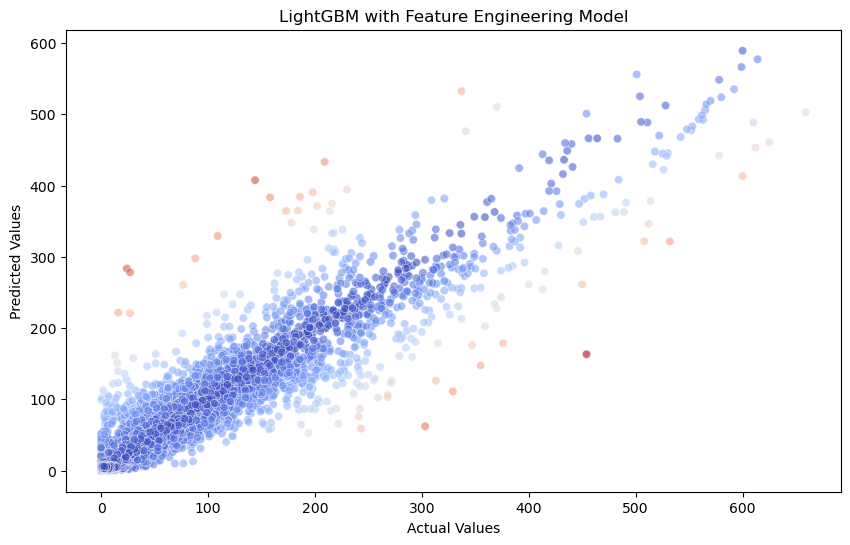

In [19]:
title = 'LightGBM with Feature Engineering Model'
file_name = 'lightgbm_with_fe_scatter.png'
output_dir = VISUALIZATIONS_DIR

plot_actual_predicted_scatter(y_test, predictions, residuals, output_dir, title, file_name)

In [18]:
best_params={
    'num_leaves': 241, 
    'feature_fraction': 0.9173905717971508, 
    'bagging_fraction': 0.8850277325059562, 
    'min_child_samples': 70
}

In [19]:
lgbm_regressor = lgb.LGBMRegressor(random_state=42, **best_params)

In [20]:
pipeline = make_pipeline(add_feature_average_rides_last_4_weeks, add_temporal_features, lgbm_regressor)
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9173905717971508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9173905717971508
[LightGBM] [Warning] bagging_fraction is set=0.8850277325059562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8850277325059562


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x13092cd30>)),
                ('temporalfeaturesengineer', TemporalFeaturesEngineer()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.8850277325059562,
                               feature_fraction=0.9173905717971508,
                               min_child_samples=70, num_leaves=241,
                               random_state=42))])

In [21]:
predictions_2 = pipeline.predict(X_test)

In [22]:
residuals_2 = y_test - predictions_2

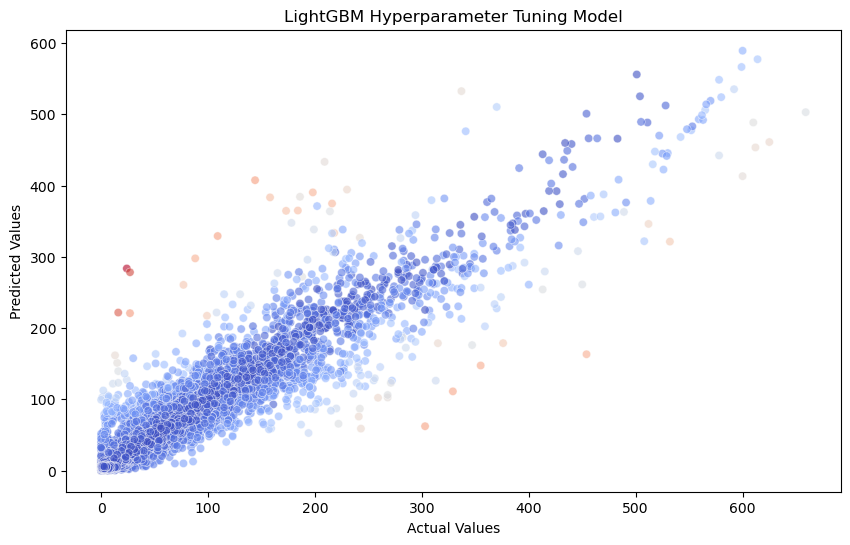

In [25]:
absolute_residuals = np.abs(residuals_2)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, c=absolute_residuals, cmap='coolwarm', alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('LightGBM Hyperparameter Tuning Model')
plt.savefig(VISUALIZATIONS_DIR / 'lightgbm_ht_scatterplot.png')
plt.show()